In [1]:
# Python implementation of nonlocal graphene simulation
import numpy as np
from scipy.linalg import norm, solve, toeplitz
from scipy.fft import fft, ifft, fftfreq
from math import floor
import matplotlib.pyplot as plt
from time import time
import warnings
warnings.filterwarnings('ignore')
defaultDPI = 1200

In [2]:
# Physical Parameters
T = 'M' # Choice of polarization, 'E' for transverse electric, 'M' for magnetic.
epsilon_u = 3; epsilon_w = 4 # Permittivities
D = [1,2,4,8] # Lateral period (mum)
Aloc, Anloc = {}, {}
for d in D:
    Aloc[d], Anloc[d] = [], [] # Absorbance for each period
theta = 0 # Incident angle
N = [0,1] # Normal vector
EF = 0.4 # Fermi level position (eV)
vF = 1 # Fermi velocity (mum/s)
tau = 0.09 # Carrier lifetime (s)
tau_u = (T=='E') + (T=='M')/epsilon_u; tau_w = (T=='E') + (T=='M')/epsilon_w # Equation coefficients
C2 = (T=='E') + (T=='M')*(epsilon_u/epsilon_w) # Scaling factor

# Numerical Parameters
Nx = 128 # Physical precision
Nf = 128 # Frequency precision
L = 16 # Perturbation order
delta = 1 # Perturbation parameter
I = np.eye(Nx) # Identity matrix
P = fftfreq(Nx)*Nx # Fourier wavenumber = sample frequencies * signal size
F = np.linspace(1,13,Nf) # Incident linear frequency (THz)

# Physical Constants
Tc = 2.9979e2 # Speed of light (Tmum/s)
hT = 4.1357e-3 # Planck’s constant (eV/THz)
hBarT = 6.5821e-4 # Dirac constant hBar = h/(2pi)
hc = 1.2398 # Precomputed h*c
Gamma = 3.7e-3 # hBar * relaxation rate (eV)
e2epsilon0 = 55.2635 # Vacuum permittivity (e^2/eV/mum)

In [3]:
# padesum - Sums a truncated Taylor series via Pade approximation. Adopted from David Nicholls
# Inputs:
# c - Taylor series coefficients: [c_0,...,c_N]
# Eps - Value at which to sum
# M - Numerator and denominator degree (M = N/2)
# Output: Pade approximant evaluated at Eps
def padesum(c,Eps,M):
    c = np.array(c)
    if M==0:
        a = np.array([c[0]]); b = np.array([1])
    else:
        H = toeplitz(c[M:2*M], c[M::-1][:M])
        bb = -solve(H, c[M+1:2*M+1])
        b = np.concatenate([np.array([1]),bb])
        aa = np.convolve(b, c[0:M+1])
        a = aa[0:M+1]
    return np.polyval(a[::-1], Eps) / np.polyval(b[::-1], Eps)

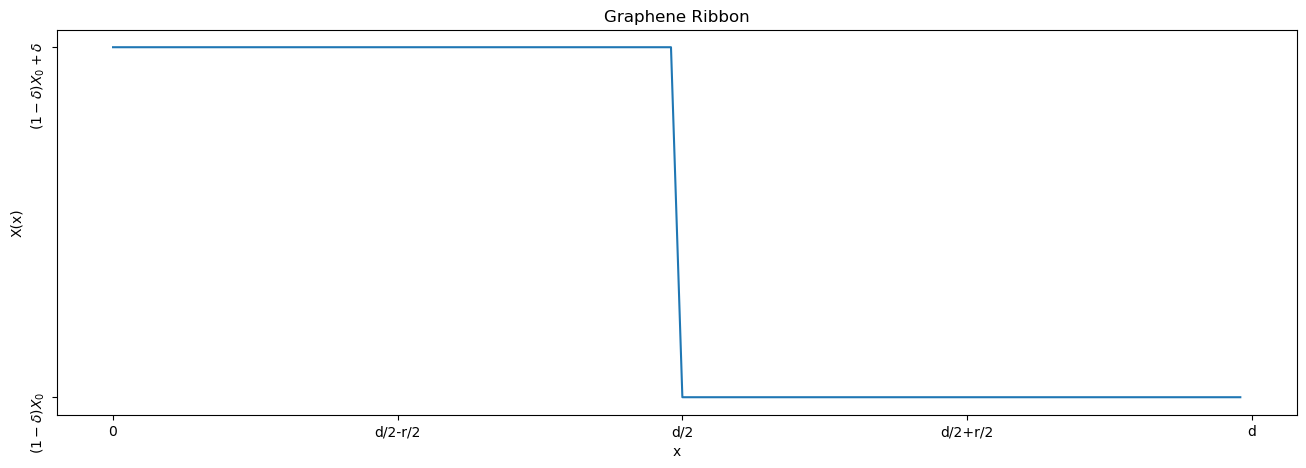

In [4]:
# Graphene Ribbon Envelope Function Shape
ribbon = 'step' # 'smooth' or 'step' graphene ribbon, note 'step' will cause singular matrix with TE
X0 = 1
d = D[3]; w = d/2; x = np.linspace(0,d,100,endpoint=False)
if ribbon == 'smooth':
    X = lambda x: X0+delta*(-X0+np.sqrt(1-4*((x-d/2)/w)**2)) if (d/2-w/2<x and x<d/2+w/2) else (1-delta)*X0
elif ribbon == 'step':
    X = lambda x: X0 if x<d/2 else (1-delta)*X0
plt.figure(figsize=(16,5))
plt.plot(x, list(map(X,x)))
plt.xlabel('x'); plt.xticks([0,2,4,6,8],['0','d/2-r/2','d/2','d/2+r/2','d'])
plt.ylabel('X(x)'); plt.yticks([0,1],[r'$(1-\delta)X_0$',r'$(1-\delta)X_0+\delta$'],rotation=90)
plt.title('Graphene Ribbon')
plt.savefig('image/ribbon_{}.png'.format(ribbon), dpi=defaultDPI, bbox_inches='tight')
plt.show()

In [5]:
# HOPE method
start = time()
Aloc, Anloc, Tloc, Tnloc = {}, {}, {}, {} # Absorbance spectra and Dirichlet trace
for d in D:
    Aloc[d], Anloc[d], Tloc[d], Tnloc[d] = [], [], {}, {}
    x = np.linspace(0,d,Nx,endpoint=False) # x=d omitted for periodicity
    # Envelope function
    w = d/2
    if ribbon == 'smooth':
        X1 = lambda x: -X0+np.sqrt(1-4*((x-d/2)/w)**2) if (d/2-w/2<x and x<d/2+w/2) else -X0
    elif ribbon == 'step':
        X1 = lambda x: 0 if x<d/2 else -X0
    for f in F:
        # Equation coefficients
        omega = f*2*np.pi # Angular frequency
        k0 = omega/Tc; ku = np.sqrt(epsilon_u)*k0; kw = np.sqrt(epsilon_w)*k0 # Dielectric wavenumber
        alpha = ku*np.sin(theta); alpha_p = alpha+2*np.pi/d*P
        gamma_u = ku*np.cos(theta); gamma_w = kw*np.cos(theta); gamma_up, gamma_wp = [], []
        for idx in range(Nx):
            if alpha_p[idx]**2<=ku**2:
                gamma_up.append(np.sqrt(ku**2-alpha_p[idx]**2))
            else:
                gamma_up.append(1j*np.sqrt(alpha_p[idx]**2-ku**2))
            if alpha_p[idx]**2<=kw**2:
                gamma_wp.append(np.sqrt(kw**2-alpha_p[idx]**2))
            else:
                gamma_wp.append(1j*np.sqrt(alpha_p[idx]**2-kw**2))
        gamma_up, gamma_wp = np.array(gamma_up), np.array(gamma_wp)
        G0 = np.diag(-1j*gamma_up); J0 = np.diag(-1j*gamma_wp) # DNOs in Fourier space
        xi = -np.ones(Nx); nu = 1j*gamma_u*np.ones(Nx) # Boundary conditions
        # Model coefficients
        sigma0 = 2*EF/(hc*e2epsilon0*(Gamma-1j*hBarT*omega)) # linear model
        A0 = (T=='M')*norm(N)*sigma0/(1j*k0); B0 = (T=='E')*1j*k0*sigma0/norm(N) # constant part
        sigmaBGK = sigma0*vF**2*(3*f+2j/tau)/(4*f*(f+1j/tau)**2) # nonlinear model
        A1 = (T=='M')*norm(N)*sigmaBGK/(1j*k0); B1 = (T=='E')*1j*k0*sigmaBGK/norm(N) # operater part
        # Solution (Dirichlet traces at each perturbation order)
        U, Uhat, W, What = {}, {}, {}, {}
        
        # Local Iteration
        LHS = np.block([[I,-I+A0*X0*tau_w*J0],[tau_u*G0,tau_w*J0-B0*X0*I]]) # Decompose to 2x2 matrices will run slower
        #Decompose# LHS = {}
        #Decompose# for idx in range(Nx):
        #Decompose#     LHS[idx] = np.array([[1,-1+A0*X0*tau_w*J0[idx,idx]],[tau_u*G0[idx,idx],tau_w*J0[idx,idx]-B0*X0]])
        RHS1 = xi; RHS2 = -tau_u*nu
        for ell in range(L+1):
            Sol = solve(LHS,np.concatenate((fft(RHS1),fft(RHS2))))
            #Decompose# T1 = fft(RHS1); T2 = fft(RHS2); Sol = {}
            #Decompose# for idx in range(Nx):
            #Decompose#     sol = solve(LHS[idx], np.array([T1[idx], T2[idx]]))
            #Decompose#     Sol[idx], Sol[idx+Nx] = sol[0], sol[1]
            #Decompose# Sol = list(dict(sorted(Sol.items())).values())
            Uhat[ell] = Sol[:Nx]; U[ell] = ifft(Uhat[ell])
            What[ell] = Sol[Nx:]; W[ell] = ifft(What[ell])
            if ell < L:
                Vhat = tau_w*J0.dot(What[ell])
                RHS1 = -A0*np.array(list(map(X1,x)))*ifft(Vhat)
                RHS2 = B0*np.array(list(map(X1,x)))*W[ell]
        # Add up all perturbation orders via Pade sum
        Uhat_p, What_p = [], [] # Recovered Dirichlet traces in Fourier Space
        for idx in range(Nx):
            coeff = [uhat[idx] for uhat in Uhat.values()]
            Uhat_p.append(padesum(coeff,delta,floor(L/2))/Nx)
            coeff = [what[idx] for what in What.values()]
            What_p.append(padesum(coeff,delta,floor(L/2))/Nx)
        Uhat_p, What_p = np.array(Uhat_p), np.array(What_p)
        # Absorbance spectra
        e_up = gamma_up*(Uhat_p*np.conjugate(Uhat_p))/gamma_up[0]
        e_wp = gamma_wp*(What_p*np.conjugate(What_p))/gamma_up[0]
        R = (alpha_p**2<=ku**2).dot(e_up)
        S = (alpha_p**2<=kw**2).dot(e_wp)
        Aloc[d].append(1-R-C2*S)
        Tloc[d][f] = ifft(Uhat_p)

        # Nonlocal
        P2 = np.diag(P**2) # 2nd order derivative becomes multiplier -p^2 in Fourier space
        LHS = np.block([[I,-I+A0*X0*tau_w*J0+A1*X0*tau_w*P2*J0],[tau_u*G0,tau_w*J0-B0*X0*I-B1*X0*P2]])
        RHS1 = xi; RHS2 = -tau_u*nu
        for ell in range(L+1):
            Sol = solve(LHS,np.concatenate((fft(RHS1),fft(RHS2))))
            Uhat[ell] = Sol[:Nx]; U[ell] = ifft(Uhat[ell])
            What[ell] = Sol[Nx:]; W[ell] = ifft(What[ell])
            if ell < L:
                Vhat = tau_w*J0.dot(What[ell])
                RHS1 = -A0*np.array(list(map(X1,x)))*ifft(Vhat) -A1*np.array(list(map(X1,x)))*ifft(P**2*Vhat)
                RHS2 = B0*np.array(list(map(X1,x)))*W[ell] +B1*np.array(list(map(X1,x)))*ifft(P**2*What[ell])
        Uhat_p, What_p = [], []
        for idx in range(Nx):
            coeff = [uhat[idx] for uhat in Uhat.values()]
            Uhat_p.append(padesum(coeff,delta,floor(L/2))/Nx)
            coeff = [what[idx] for what in What.values()]
            What_p.append(padesum(coeff,delta,floor(L/2))/Nx)
        Uhat_p, What_p = np.array(Uhat_p), np.array(What_p)
        e_up = gamma_up*(Uhat_p*np.conjugate(Uhat_p))/gamma_up[0]
        e_wp = gamma_wp*(What_p*np.conjugate(What_p))/gamma_up[0]
        R = (alpha_p**2<=ku**2).dot(e_up)
        S = (alpha_p**2<=kw**2).dot(e_wp)
        Anloc[d].append(1-R-C2*S)
        Tnloc[d][f] = ifft(Uhat_p)
end = time() 
print('HOPE runtime:', end-start) # Expect <120s

HOPE runtime: 90.97028112411499


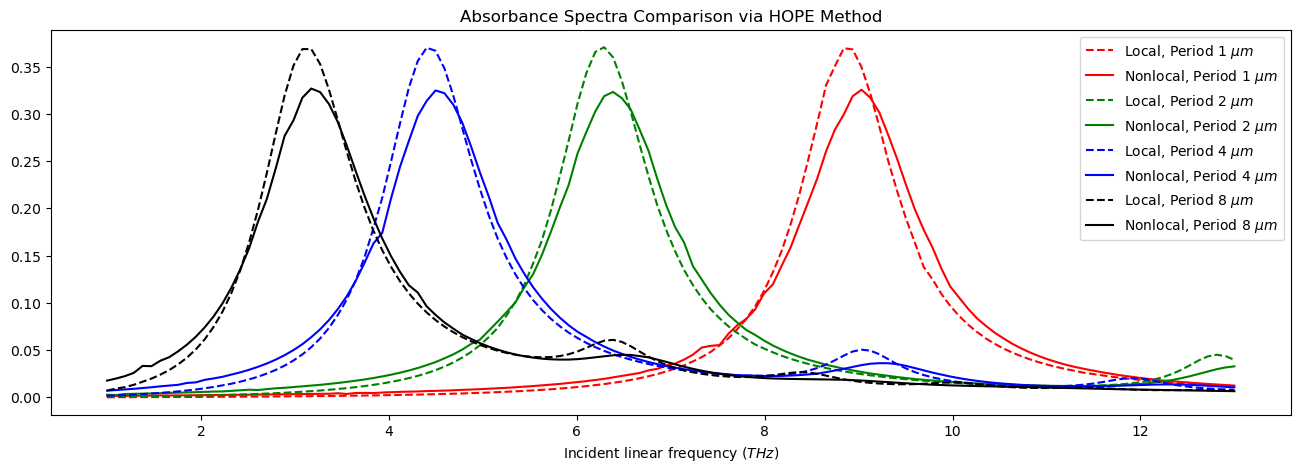

In [6]:
colors = ['r','g','b','k']
plt.figure(figsize=(16,5))
for idx in range(len(D)):
    d = D[idx]
    plt.plot(F, Aloc[d], '--', color=colors[idx], label=r'Local, Period {} $\mu m$'.format(d))
    plt.plot(F, Anloc[d], color=colors[idx], label=r'Nonlocal, Period {} $\mu m$'.format(d))
plt.xlabel(r'Incident linear frequency $(THz)$')
plt.title('Absorbance Spectra Comparison via HOPE Method')
plt.legend()
plt.savefig('image/absorbHOPE_T{}_{}.png'.format(T,ribbon), dpi=defaultDPI, bbox_inches='tight')
plt.show()

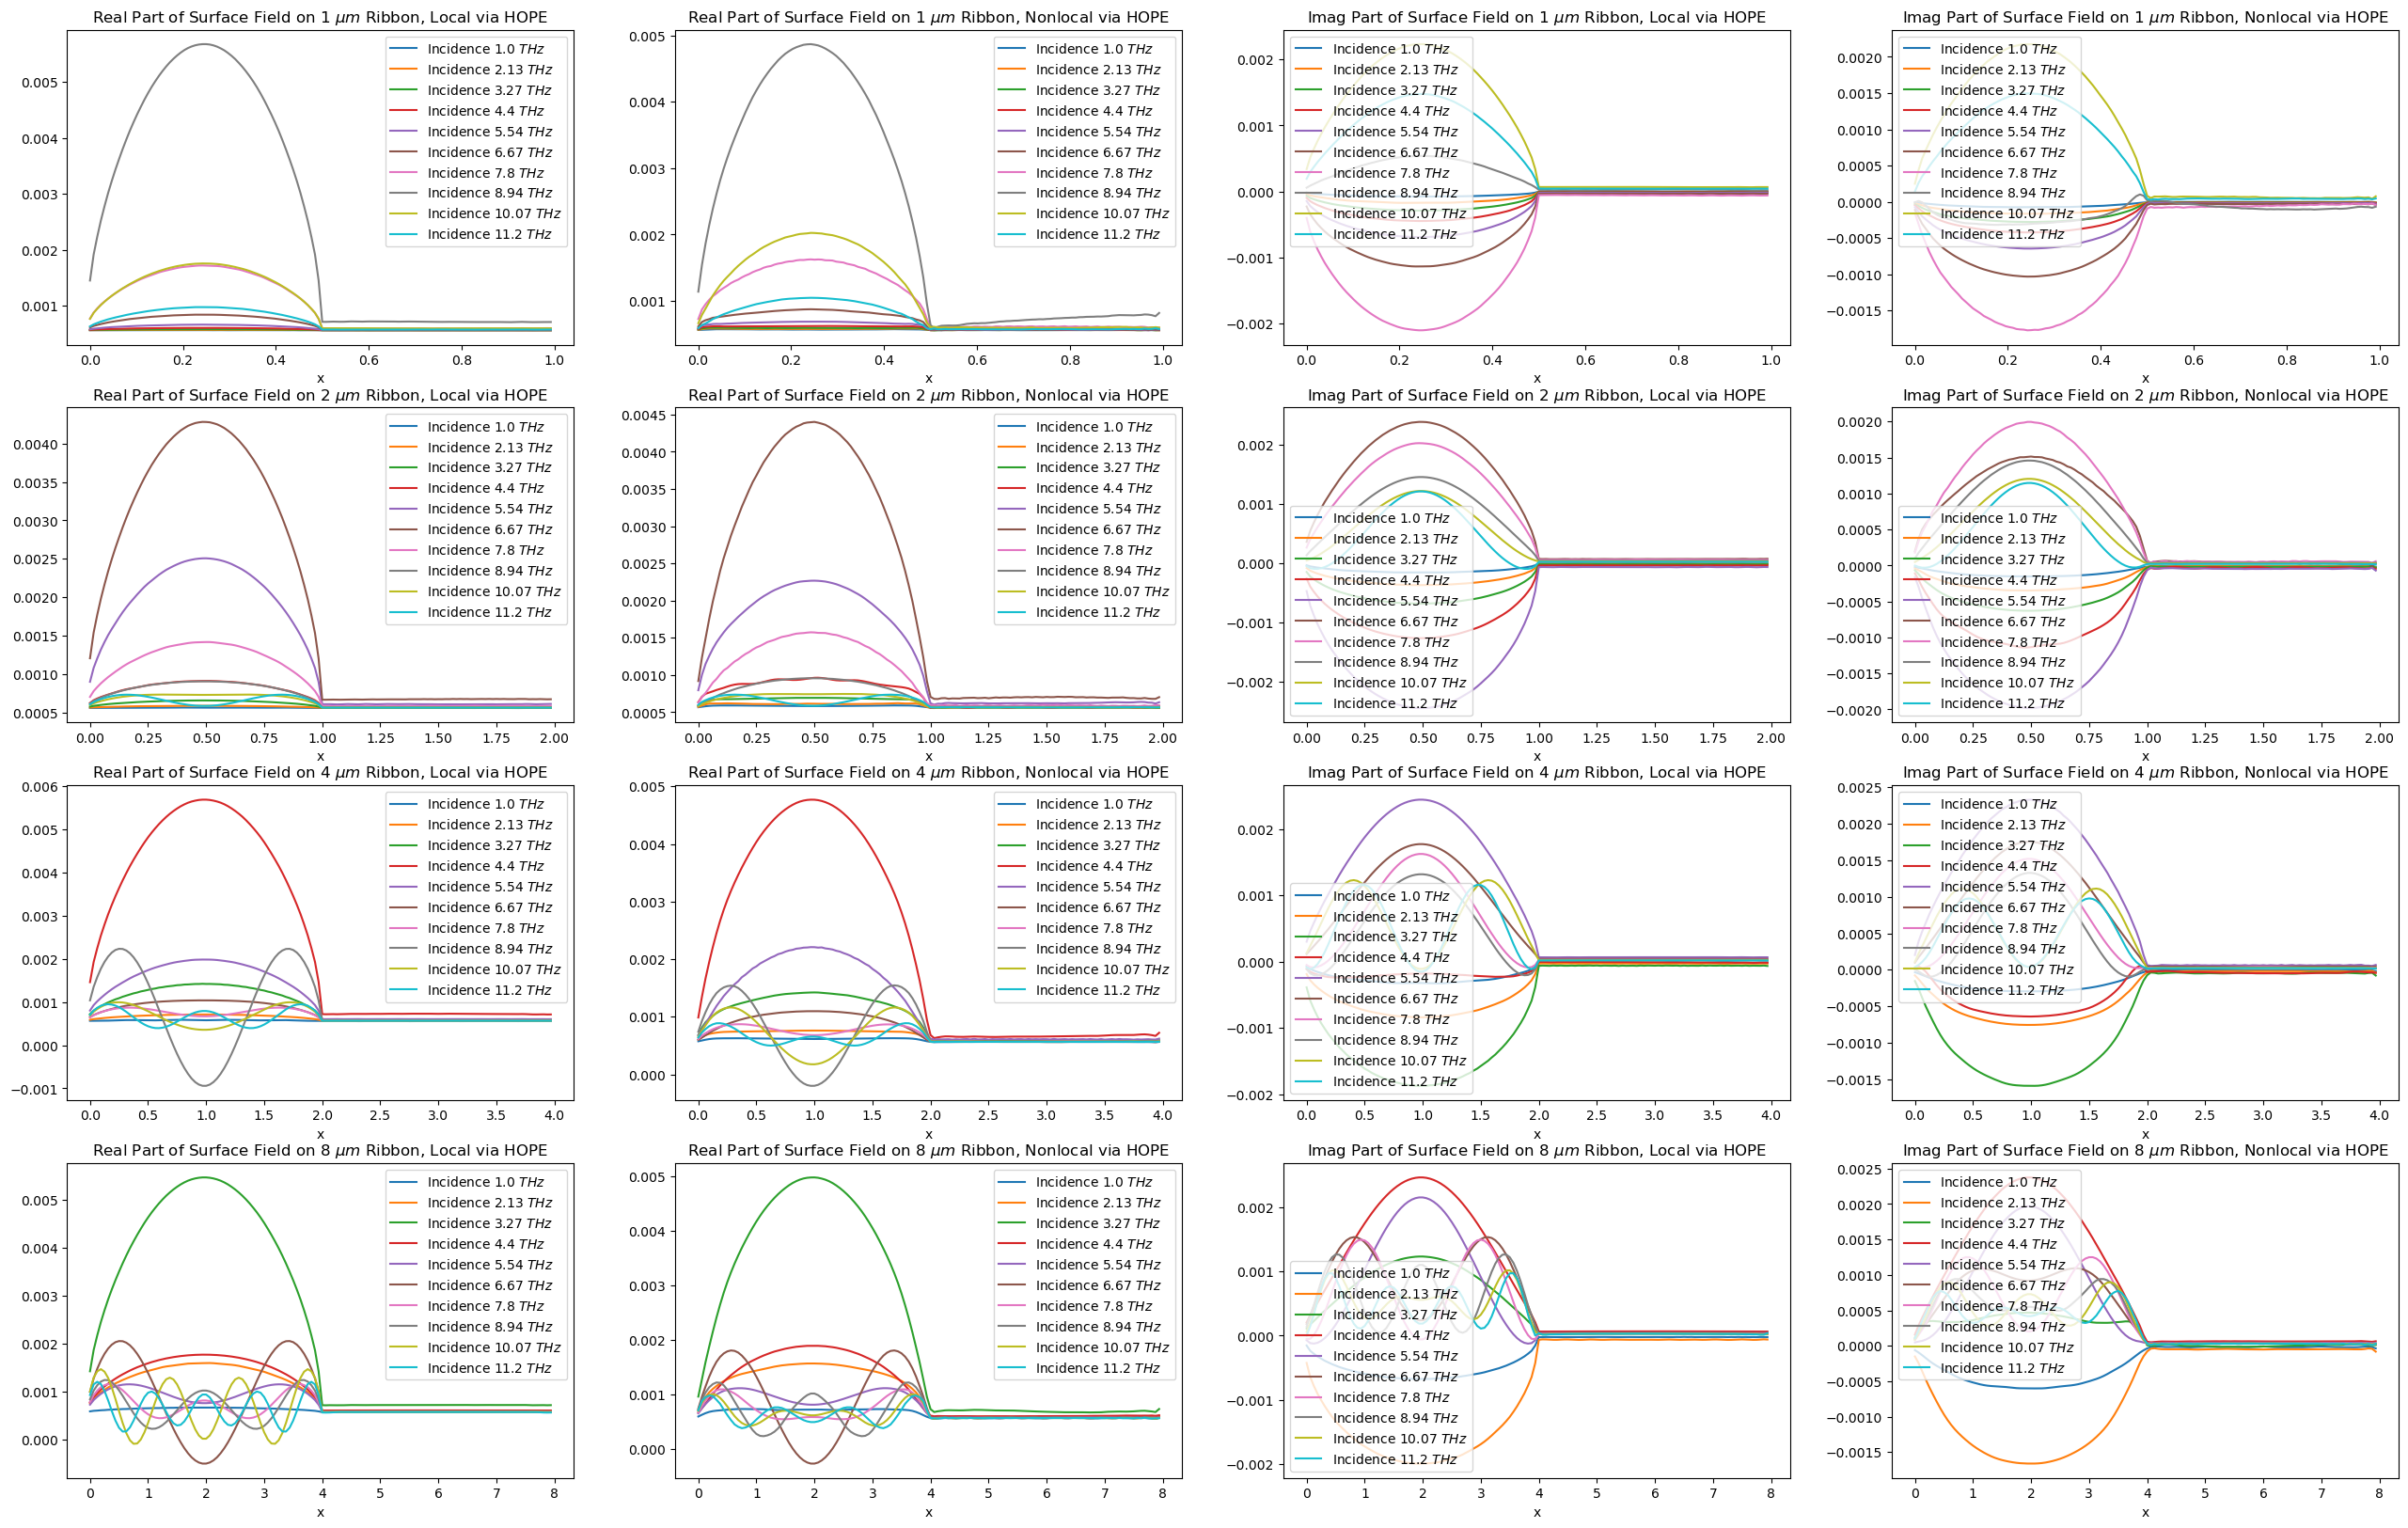

In [7]:
freqSampleSize = 10
Fsample = [F[idx*floor(Nf/freqSampleSize)] for idx in range(freqSampleSize)]
plt.subplots(len(D),4,figsize=(32,5*len(D)))
for idx in range(len(D)):
    d = D[idx]
    x = np.linspace(0,d,Nx,endpoint=False)
    
    plt.subplot(len(D),4,4*idx+1)
    for f in Fsample:
        plt.plot(x, np.real(Tloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Real Part of Surface Field on {} $\mu m$ Ribbon, Local via HOPE'.format(d))
    plt.xlabel('x'); plt.legend()
    
    plt.subplot(len(D),4,4*idx+2)
    for f in Fsample:
        plt.plot(x, np.real(Tnloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Real Part of Surface Field on {} $\mu m$ Ribbon, Nonlocal via HOPE'.format(d))
    plt.xlabel('x'); plt.legend()

    plt.subplot(len(D),4,4*idx+3)
    for f in Fsample:
        plt.plot(x, np.imag(Tloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Imag Part of Surface Field on {} $\mu m$ Ribbon, Local via HOPE'.format(d))
    plt.xlabel('x'); plt.legend()
    
    plt.subplot(len(D),4,4*idx+4)
    for f in Fsample:
        plt.plot(x, np.imag(Tnloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Imag Part of Surface Field on {} $\mu m$ Ribbon, Nonlocal via HOPE'.format(d))
    plt.xlabel('x'); plt.legend()
plt.savefig('image/surfaceHOPE_T{}_{}.png'.format(T,ribbon), dpi=defaultDPI, bbox_inches='tight')
plt.show()

In [8]:
# Collocation Method
start = time()
for d in D:
    Aloc[d], Anloc[d] = [], []
    x = np.linspace(0,d,Nx,endpoint=False)
    w = d/2
    if ribbon == 'smooth':
        X = lambda x: X0+delta*(-X0+np.sqrt(1-4*((x-d/2)/w)**2)) if (d/2-w/2<x and x<d/2+w/2) else (1-delta)*X0
    elif ribbon == 'step':
        X = lambda x: X0 if x<d/2 else (1-delta)*X0
    Xx = np.diag(list(map(X,x)))
    for f in F:
        omega = f*2*np.pi
        k0 = omega/Tc; ku = np.sqrt(epsilon_u)*k0; kw = np.sqrt(epsilon_w)*k0
        alpha = ku*np.sin(theta); alpha_p = alpha+2*np.pi/d*P
        gamma_u = ku*np.cos(theta); gamma_w = kw*np.cos(theta); gamma_up, gamma_wp = [], []
        for idx in range(Nx):
            if alpha_p[idx]**2<=ku**2:
                gamma_up.append(np.sqrt(ku**2-alpha_p[idx]**2))
            else:
                gamma_up.append(1j*np.sqrt(alpha_p[idx]**2-ku**2))
            if alpha_p[idx]**2<=kw**2:
                gamma_wp.append(np.sqrt(kw**2-alpha_p[idx]**2))
            else:
                gamma_wp.append(1j*np.sqrt(alpha_p[idx]**2-kw**2))
        gamma_up, gamma_wp = np.array(gamma_up), np.array(gamma_wp)
        xi = -np.ones(Nx); nu = 1j*gamma_u*np.ones(Nx)
        sigma0 = 2*EF/(hc*e2epsilon0*(Gamma-1j*hBarT*omega))
        A0 = (T=='M')*norm(N)*sigma0/(1j*k0); B0 = (T=='E')*1j*k0*sigma0/norm(N)
        sigmaBGK = sigma0*vF**2*(3*f+2j/tau)/(4*f*(f+1j/tau)**2)
        A1 = (T=='M')*norm(N)*sigmaBGK/(1j*k0); B1 = (T=='E')*1j*k0*sigmaBGK/norm(N)
        
        # Recover physical DNOs and differentiation matrix
        G0hat = np.diag(-1j*gamma_up); J0hat = np.diag(-1j*gamma_wp) # DNOs in Fourier space
        G0, J0, Diff = 1j*np.eye(Nx), 1j*np.eye(Nx), 1j*np.eye(Nx)
        for idx in range(Nx):
            G0[:,idx] = ifft(G0hat.dot(fft(I[:,idx])))
            J0[:,idx] = ifft(J0hat.dot(fft(I[:,idx])))
            Diff[:,idx] = ifft(np.diag(1j*P).dot(fft(I[:,idx])))
        Diff2 = Diff.dot(Diff)
        
        # Local Setup
        LHS = np.block([[I, -I+A0*tau_w*Xx.dot(J0)], [tau_u*G0, tau_w*J0-B0*Xx]])
        RHS = np.concatenate((xi, -tau_u*nu))
        Sol = solve(LHS, RHS)
        U = Sol[:Nx]; Uhat = fft(U)/Nx
        W = Sol[Nx:]; What = fft(W)/Nx
        e_up = gamma_up*(Uhat*np.conjugate(Uhat))/gamma_up[0]
        e_wp = gamma_wp*(What*np.conjugate(What))/gamma_up[0]
        R = (alpha_p**2<=ku**2).dot(e_up)
        S = (alpha_p**2<=kw**2).dot(e_wp)
        Aloc[d].append(1-R-C2*S)
        Tloc[d][f] = U

        # Nonlocal
        LHS = np.block([[I, -I+tau_w*(A0*I-A1*Diff2).dot(Xx).dot(J0)], [tau_u*G0, tau_w*J0-(B0*I-B1*Diff2).dot(Xx)]])
        Sol = solve(LHS, RHS)
        U = Sol[:Nx]; Uhat = fft(U)/Nx
        W = Sol[Nx:]; What = fft(W)/Nx
        e_up = gamma_up*(Uhat*np.conjugate(Uhat))/gamma_up[0]
        e_wp = gamma_wp*(What*np.conjugate(What))/gamma_up[0]
        R = (alpha_p**2<=ku**2).dot(e_up)
        S = (alpha_p**2<=kw**2).dot(e_wp)
        Anloc[d].append(1-R-C2*S)
        Tnloc[d][f] = U
end = time()
print('Collocation runtime:', end-start) # Expect <20s

Collocation runtime: 14.219422578811646


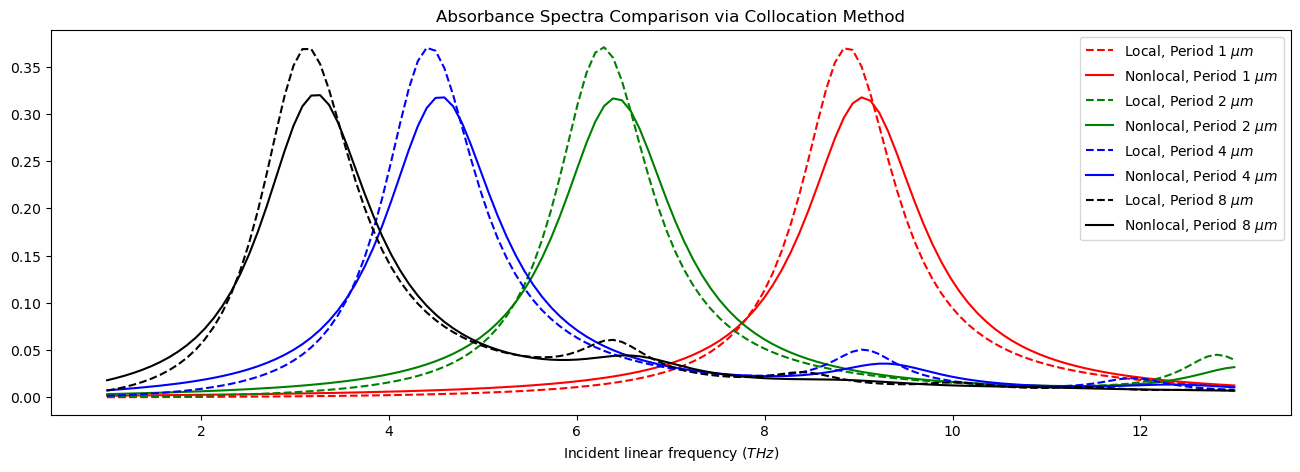

In [9]:
colors = ['r','g','b','k']
plt.figure(figsize=(16,5))
for idx in range(len(D)):
    d = D[idx]
    plt.plot(F, Aloc[d], '--', color=colors[idx], label=r'Local, Period {} $\mu m$'.format(d))
    plt.plot(F, Anloc[d], color=colors[idx], label=r'Nonlocal, Period {} $\mu m$'.format(d))
plt.xlabel(r'Incident linear frequency $(THz)$')
plt.title('Absorbance Spectra Comparison via Collocation Method')
plt.legend()
plt.savefig('image/absorbCollocation_T{}_{}.png'.format(T,ribbon), dpi=defaultDPI, bbox_inches='tight')
plt.show()

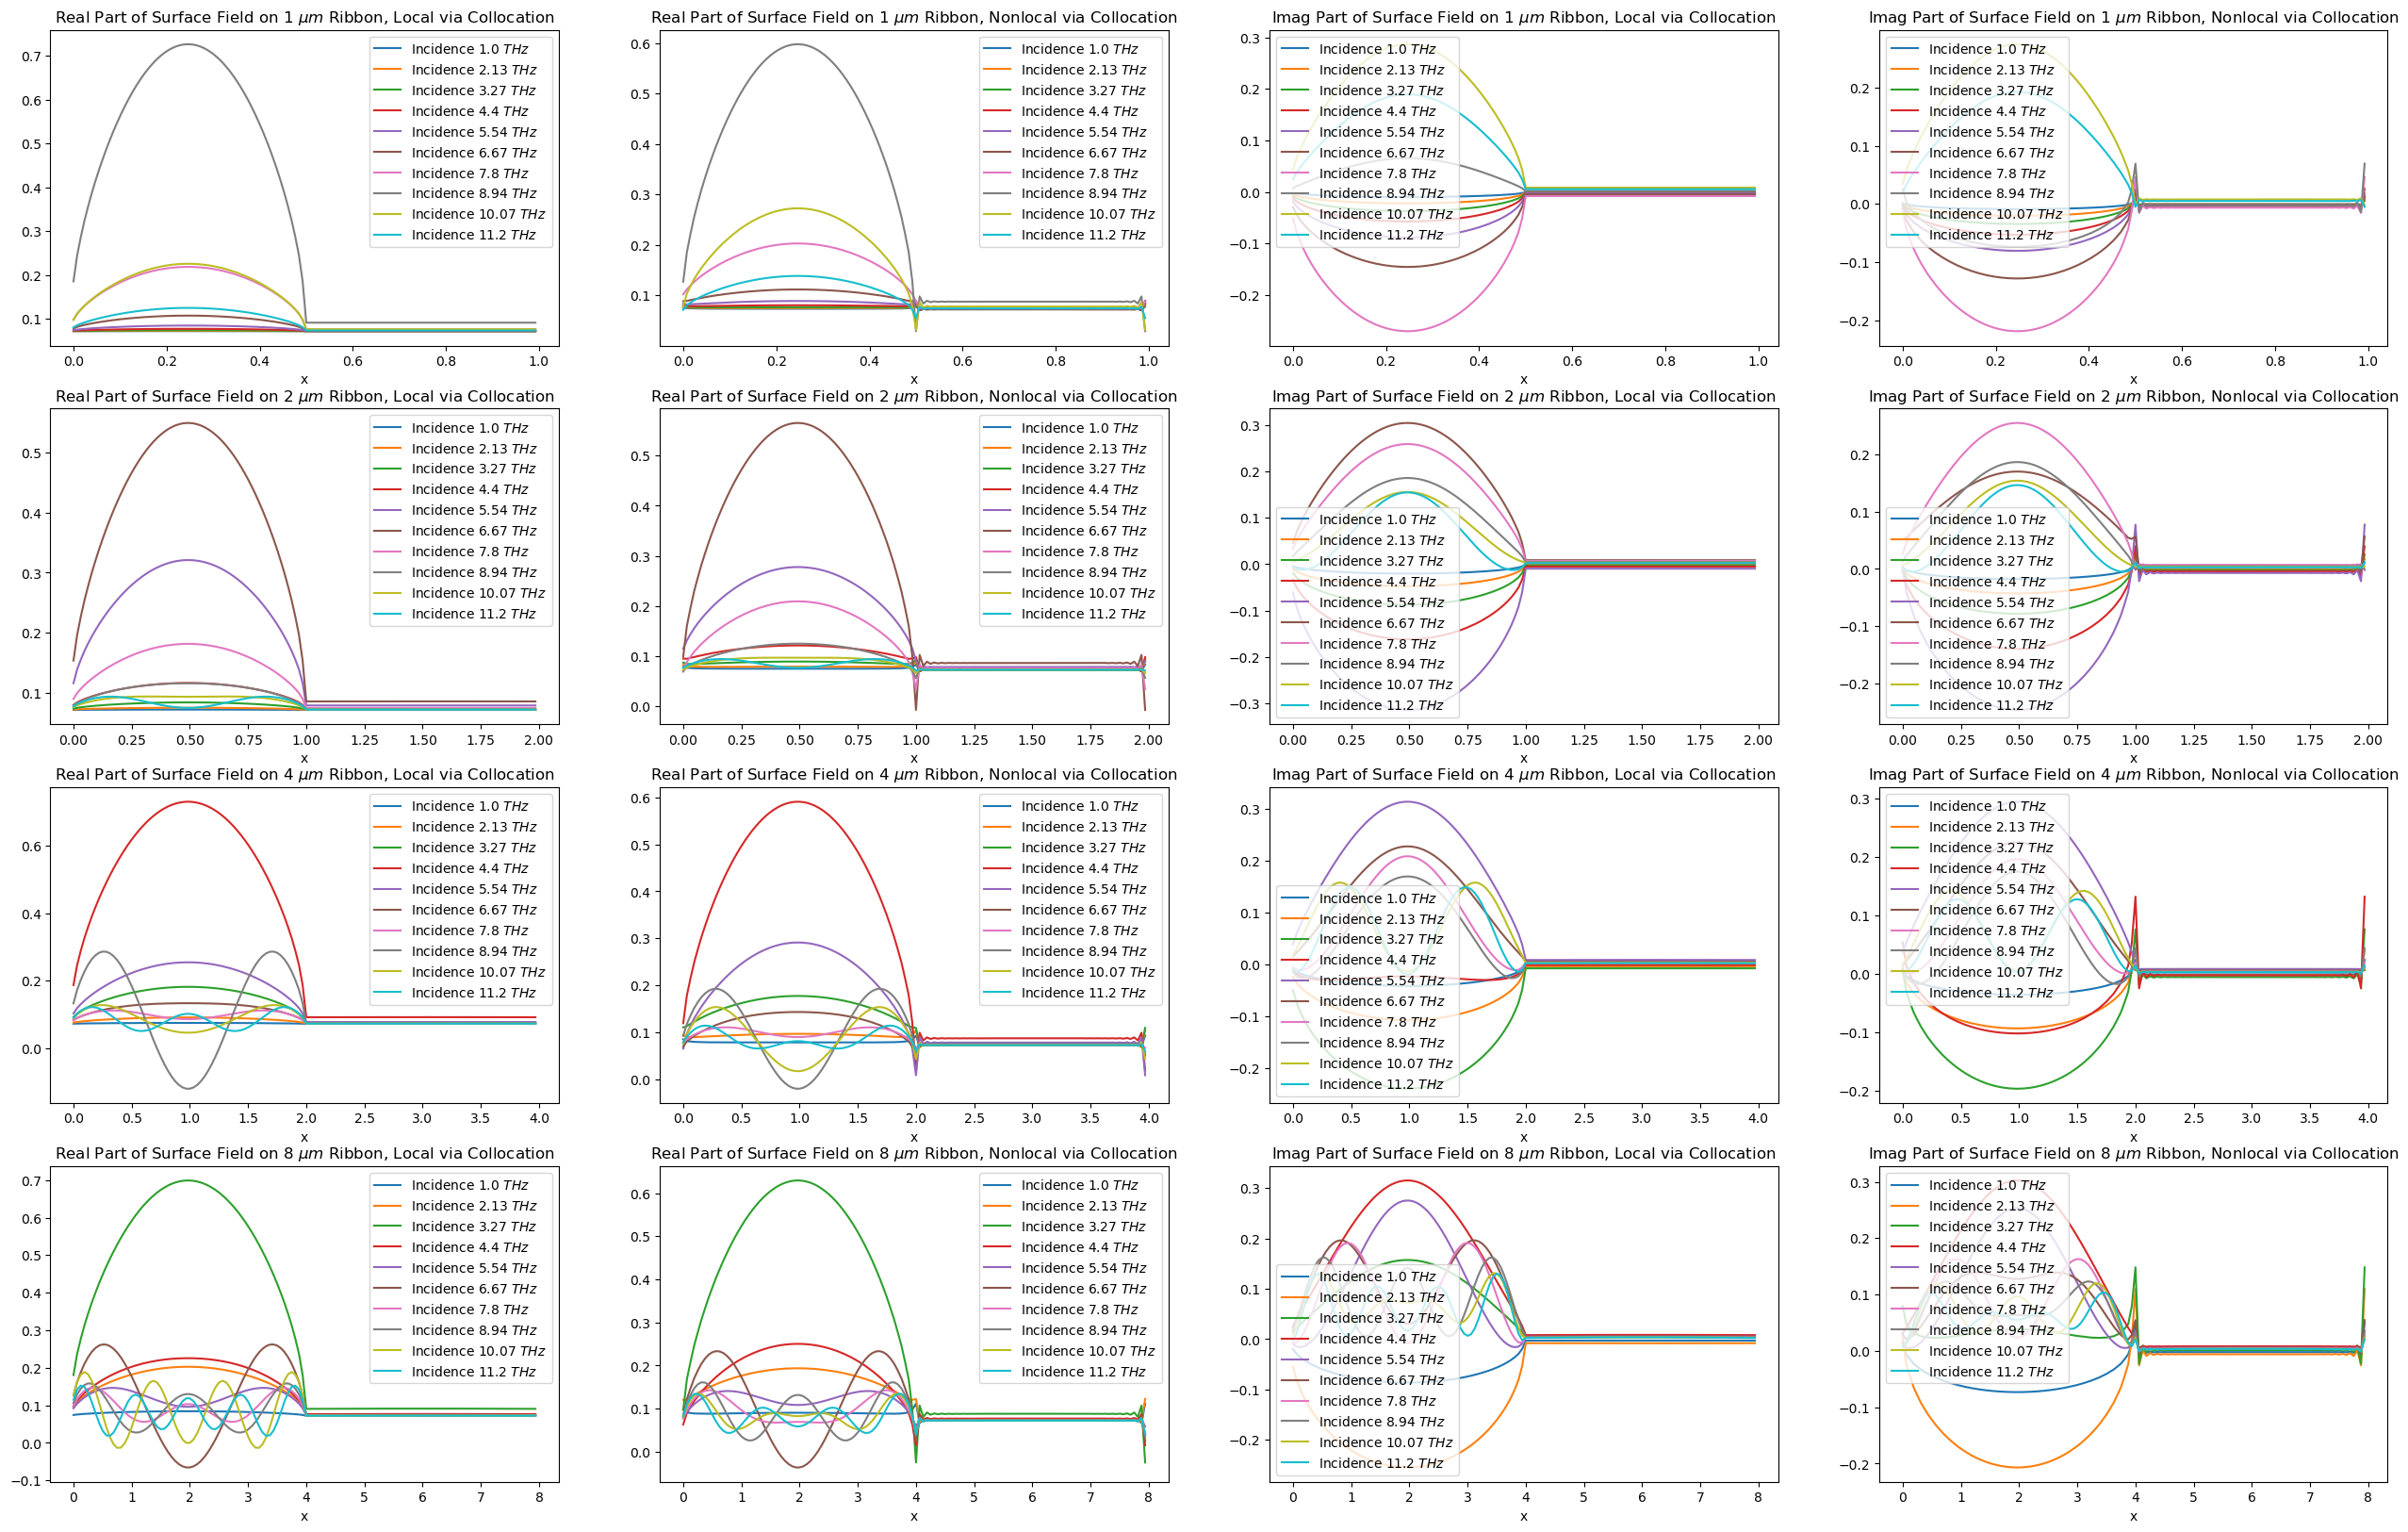

In [10]:
plt.subplots(len(D),4,figsize=(32,5*len(D)))
for idx in range(len(D)):
    d = D[idx]
    x = np.linspace(0,d,Nx,endpoint=False)
    
    plt.subplot(len(D),4,4*idx+1)
    for f in Fsample:
        plt.plot(x, np.real(Tloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Real Part of Surface Field on {} $\mu m$ Ribbon, Local via Collocation'.format(d))
    plt.xlabel('x'); plt.legend()
    
    plt.subplot(len(D),4,4*idx+2)
    for f in Fsample:
        plt.plot(x, np.real(Tnloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Real Part of Surface Field on {} $\mu m$ Ribbon, Nonlocal via Collocation'.format(d))
    plt.xlabel('x'); plt.legend()

    plt.subplot(len(D),4,4*idx+3)
    for f in Fsample:
        plt.plot(x, np.imag(Tloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Imag Part of Surface Field on {} $\mu m$ Ribbon, Local via Collocation'.format(d))
    plt.xlabel('x'); plt.legend()
    
    plt.subplot(len(D),4,4*idx+4)
    for f in Fsample:
        plt.plot(x, np.imag(Tnloc[d][f]), label = r'Incidence {} $THz$'.format(round(f,2)))
    plt.title(r'Imag Part of Surface Field on {} $\mu m$ Ribbon, Nonlocal via Collocation'.format(d))
    plt.xlabel('x'); plt.legend()
plt.savefig('image/surfaceCollocation_T{}_{}.png'.format(T,ribbon), dpi=defaultDPI, bbox_inches='tight')
plt.show()